<a href="https://colab.research.google.com/github/caurodrig7/data-analytics-portfolio/blob/main/ashby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard library imports
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Cleaning
Develop SQL to exclude:
- Outcome = active
- Department is empty
- Gender <> male/female
- Consideration date < Interview date
- Consideration date - Interview date > 90days
- Candidate with multiple genders

In [2]:
#SQL to clean Raw data file

con = duckdb.connect()
ashby_query = f"""
WITH raw_data AS (
    SELECT
        Candidate,
        Application,
        Department,
        CAST("Interview Date" AS Date) AS interview_date,
        CAST("Consideration End" AS Date) AS consideration_date,
        Outcome,
        LOWER(Gender) AS gender_norm,
        Source
    FROM read_csv_auto('ashby_data_analysis.csv', header=true)
),
gender_count AS (
  SELECT Application,
    COUNT(DISTINCT gender_norm) OVER (PARTITION BY Candidate) AS gender_cnt
  FROM raw_data
)
SELECT *
FROM raw_data r
JOIN gender_count g
  ON r.Application = g.Application
WHERE
  -- exclude Outcome = active
  r.Outcome IN ('hired','archived')
  -- Department not empty
  AND r.Department IS NOT NULL
  -- Gender must be male/female
  AND r.gender_norm IN ('male','female')
  -- Consideration date cannot be prior to interview date
  AND DATE_DIFF('day', r.interview_date, r.consideration_date) >= 0
  -- Consideration date cannot pass 90days from interview date
  AND DATE_DIFF('day', r.interview_date, r.consideration_date) <= 90
  -- Candidate must not have multiple genders
  AND g.gender_cnt = 1;
"""

df_new = con.execute(ashby_query).df()
print("Clean shape:", df_new.shape)
df_new.head()

Clean shape: (4528, 10)


,Candidate,Application,Department,interview_date,consideration_date,Outcome,gender_norm,Source,Application_1,gender_cnt
0,c92dea5f-a94a-4543-8ac8-7ccf35a57496,5671a7d9-cd19-4b2c-b224-26b829ac313c,Engineering,2023-12-20,2023-12-29,hired,male,University Hiring,5671a7d9-cd19-4b2c-b224-26b829ac313c,1
1,4057d549-31a2-4f0b-8183-cb8a29ab8111,fd9c8d33-9743-41fb-8eb3-77e1d6fec650,Engineering,2023-06-01,2023-06-09,hired,male,University Hiring,fd9c8d33-9743-41fb-8eb3-77e1d6fec650,1
2,3ff374e8-ff73-41cf-8ee3-780a0eeb5d82,60c39bbe-be09-4c91-b1ea-caf04ef77baa,Engineering,2023-10-31,2023-11-10,hired,male,Inbound Application,60c39bbe-be09-4c91-b1ea-caf04ef77baa,1
3,9c63cf98-1cc7-4831-8909-72c11fad9c7b,5b2bb402-7ba0-434f-8ed0-8c95138631e8,Engineering,2023-02-05,2023-02-17,hired,male,Inbound Application,5b2bb402-7ba0-434f-8ed0-8c95138631e8,1
4,f01eb07b-c985-4318-8f5d-088626faa3cb,8b0f3d04-9c13-4e36-8cb1-8e7cad16b214,Engineering,2023-11-30,2023-12-08,hired,male,Inbound Application,8b0f3d04-9c13-4e36-8cb1-8e7cad16b214,1


In [3]:
# Sanity check
df_new[['gender_norm']].drop_duplicates()

,gender_norm
0,male
825,female


# Exploratory Data Analysis (EDA)

## Scatter Plot analysis
- Exclude unique datapoint from 2024-01 & 2024-07
- 2023-01 kept as low volume could be true behavior

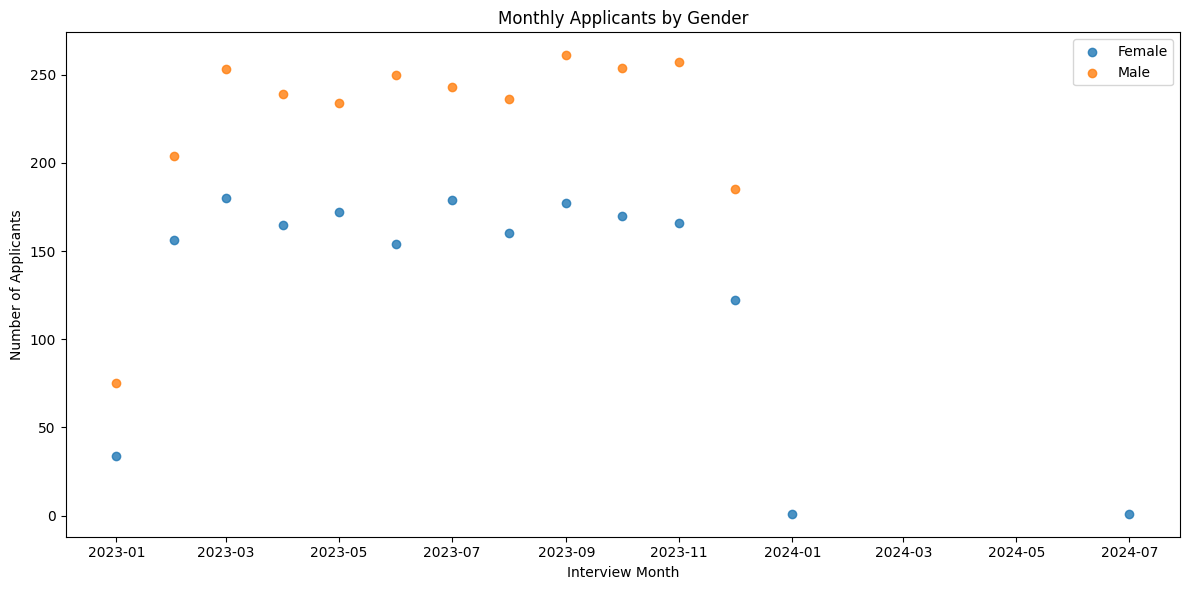

In [4]:
#Scatter Plot analysis

df_eda = df_new.copy()

# Convert Interview date to MM-YYYY
df_eda["interview_date"] = pd.to_datetime(df_eda["interview_date"])
df_eda["interview_month"] = df_eda["interview_date"].dt.to_period("M").dt.to_timestamp()

# Aggregate applicants by Month & Gender
monthly_counts = (
    df_eda.groupby(["interview_month", "gender_norm"])
      .size()
      .reset_index(name="applicants")
      .sort_values("interview_month")
)

# Full range including 0-value months
all_months = pd.date_range(
    start="2023-01-01",
    end="2024-07-01",
    freq="MS"
)

# Include 0-value months
full_index = pd.MultiIndex.from_product(
    [all_months, ["female", "male"]],
    names=["interview_month", "gender_norm"]
)
monthly_counts_full = (
    monthly_counts
        .set_index(["interview_month", "gender_norm"])
        .reindex(full_index, fill_value=0)
        .reset_index()
)

# Scatter plot: Monthly aggregation by Gender
plot_df = monthly_counts_full[monthly_counts_full["applicants"] > 0]
plt.figure(figsize=(12, 6))
# Female
plt.scatter(
    plot_df.loc[plot_df["gender_norm"] == "female", "interview_month"],
    plot_df.loc[plot_df["gender_norm"] == "female", "applicants"],
    label="Female",
    alpha=0.8
)
# Male
plt.scatter(
    plot_df.loc[plot_df["gender_norm"] == "male", "interview_month"],
    plot_df.loc[plot_df["gender_norm"] == "male", "applicants"],
    label="Male",
    alpha=0.8
)
plt.xlabel("Interview Month")
plt.ylabel("Number of Applicants")
plt.title("Monthly Applicants by Gender")
plt.legend()
plt.tight_layout()
plt.show()




In [5]:
# Drop months with near-zero sample size

df_clean = df_eda[df_eda["interview_date"].dt.year < 2024].copy()
print("Clean shape:", df_clean.shape)


Clean shape: (4526, 11)


## Quartile analysis on Interview-Consideration Lag days
- Female: typically receive decisions quickly, but there are occasional long delays
    - Median ≈ 5 days: half candidates receive a decision within 5 days
    - IQR ≈ 4–10 days: middle 50% of decisions happen in this range
    - Upper whisker ≈ 19 days: several high outliers
- Male: slightly higher median decision time and more extreme long delays
    - Median ≈ 7 days: slightly slower than for females
    - IQR ≈ 4–11 days: similar spread to females
    - Upper whisker ≈ ~21 days: more outliers than female group

<Figure size 800x600 with 0 Axes>

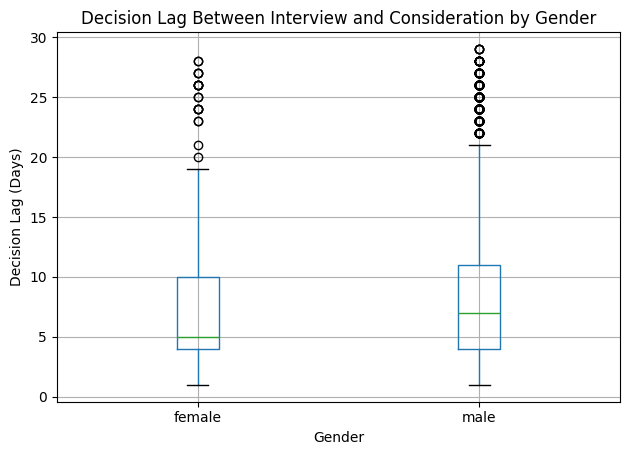

In [6]:
# Quartile analysis on Interview-Consideration Lag days

df_lag = df_clean.copy()

df_lag["interview_date"] = pd.to_datetime(df_lag["interview_date"])
df_lag["consideration_date"] = pd.to_datetime(df_lag["consideration_date"])
df_lag["decision_lag_days"] = (df_lag["consideration_date"] - df_lag["interview_date"]).dt.days

#Boxplot by Gender
plt.figure(figsize=(8, 6))
df_lag.boxplot(
    column="decision_lag_days",
    by="gender_norm"
)
plt.xlabel("Gender")
plt.ylabel("Decision Lag (Days)")
plt.title("Decision Lag Between Interview and Consideration by Gender")
plt.suptitle("")
plt.tight_layout()
plt.show()



## Application & Hiring rate by Gender over Time
- Male applicants consistently exceed female applicants every month
- Male hiring rate is consistently higher than female by 10–15 percentage points most months
- While Male hiring rates appear higher, further analysis is requred to ensure wether it is statistically significant

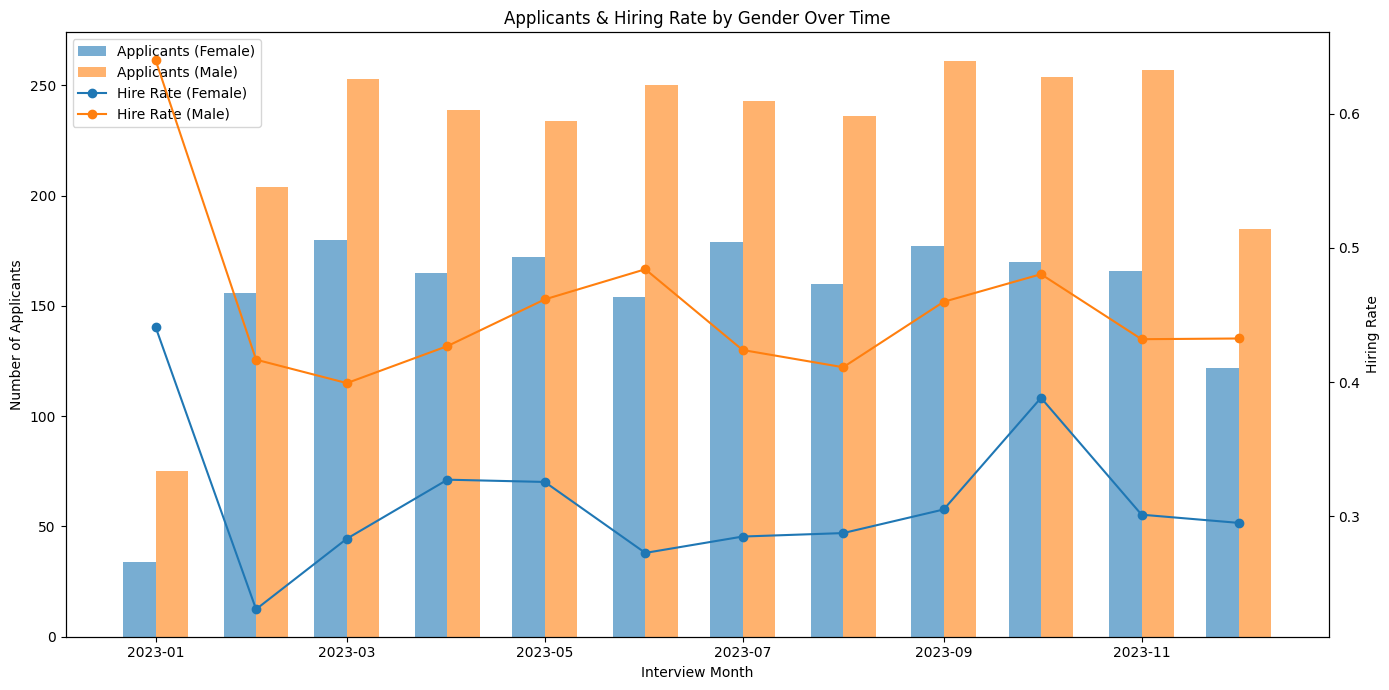

In [7]:
#Application & Hiring rate by Gender over Time

df_graph = df_clean.copy()

df_graph["interview_month"] = df_graph["interview_date"].dt.to_period("M").dt.to_timestamp()

# Aggregate applicants and hires
monthly_stats = (
    df_graph.assign(is_hired=(df_graph["Outcome"] == "hired").astype(int))
      .groupby(["interview_month", "gender_norm"])
      .agg(
          applicants=("is_hired", "size"),
          hires=("is_hired", "sum")
      )
      .reset_index()
)
#Hiring rate
monthly_stats["hire_rate"] = monthly_stats["hires"] / monthly_stats["applicants"]


#Bar chart (applications) , Line chart (Hiring rate)
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()
female = monthly_stats[monthly_stats["gender_norm"] == "female"].sort_values("interview_month")
male   = monthly_stats[monthly_stats["gender_norm"] == "male"].sort_values("interview_month")
# Bars: applicants (primary axis)
bar_width_days = 10
ax1.bar(
    female["interview_month"] - pd.Timedelta(days=5),
    female["applicants"],
    width=bar_width_days,
    alpha=0.6,
    label="Applicants (Female)"
)
ax1.bar(
    male["interview_month"] + pd.Timedelta(days=5),
    male["applicants"],
    width=bar_width_days,
    alpha=0.6,
    label="Applicants (Male)"
)
ax1.set_xlabel("Interview Month")
ax1.set_ylabel("Number of Applicants")
# Lines: hiring rate (secondary axis)
ax2.plot(
    female["interview_month"],
    female["hire_rate"],
    marker="o",
    label="Hire Rate (Female)"
)
ax2.plot(
    male["interview_month"],
    male["hire_rate"],
    marker="o",
    label="Hire Rate (Male)"
)
ax2.set_ylabel("Hiring Rate")
ax1.set_title("Applicants & Hiring Rate by Gender Over Time")
# Combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")
plt.tight_layout()
plt.show()


## Application & Hiring rate by Gender & Department
- Engineering & Product are heavily male-dominated applicant pools
- Female hiring rate higher than Male in most Departments
- While applicant volume varies substantially by Gender across Departments, hiring rates within Departments are broadly similar
- Most Gender imbalance could originate at the applicant pipeline level, not at the decision stage

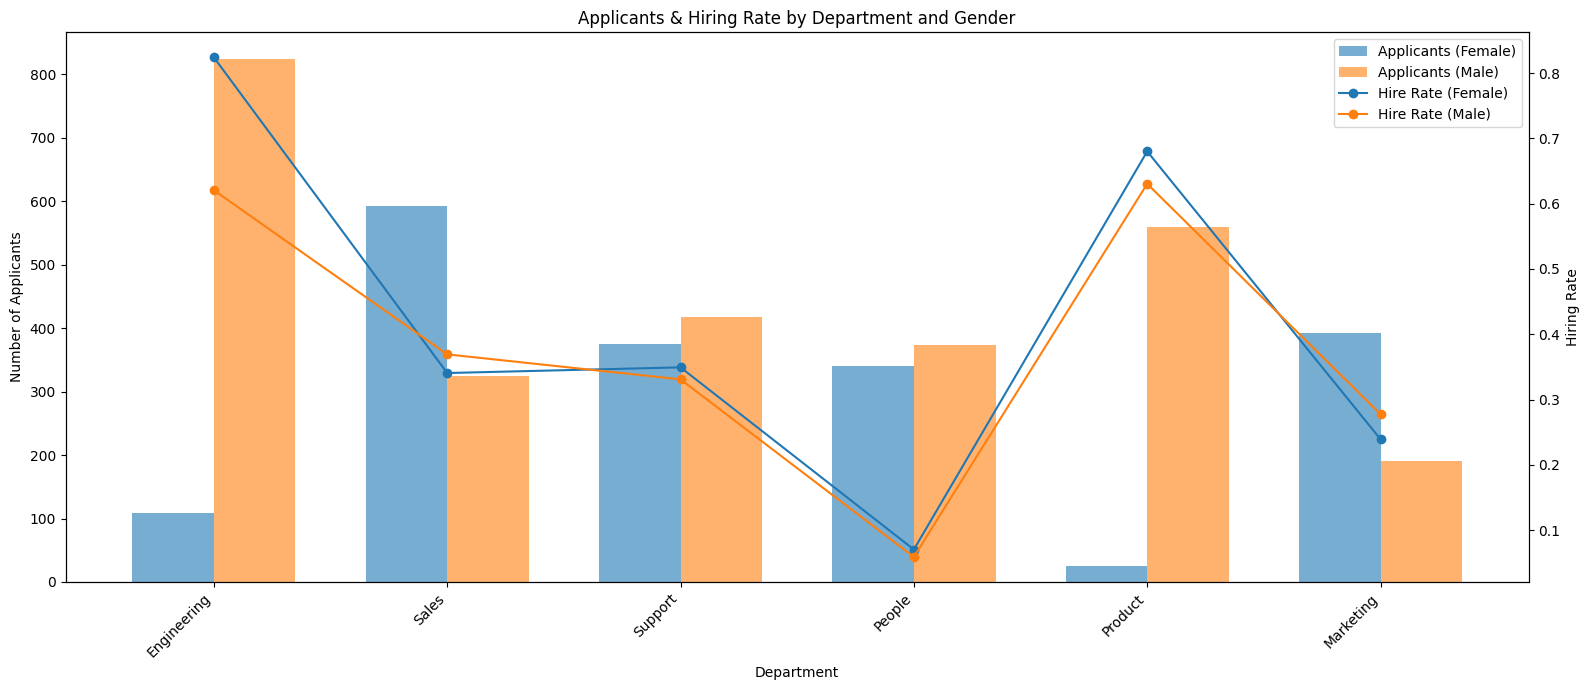

In [8]:
#Application & Hiring rate by Gender & Department

df_department = df_clean.copy()

# Aggregate by Department & Gender
dept_stats = (
    df_department.assign(is_hired=(df_department["Outcome"] == "hired").astype(int))
      .groupby(["Department", "gender_norm"])
      .agg(
          applicants=("is_hired", "size"),
          hires=("is_hired", "sum")
      )
      .reset_index()
)
# Hiring rate
dept_stats["hire_rate"] = dept_stats["hires"] / dept_stats["applicants"]

#Sort Departments
dept_order = (
    dept_stats.groupby("Department")["applicants"]
              .sum()
              .sort_values(ascending=False)
              .index
)
dept_stats["Department"] = pd.Categorical(
    dept_stats["Department"],
    categories=dept_order,
    ordered=True
)

#Chart
fig, ax1 = plt.subplots(figsize=(16, 7))
ax2 = ax1.twinx()
female = dept_stats[dept_stats["gender_norm"] == "female"].sort_values("Department")
male   = dept_stats[dept_stats["gender_norm"] == "male"].sort_values("Department")
x = range(len(dept_order))
bar_width = 0.35
#Bars: applicants (primary axis)
ax1.bar(
    [i - bar_width/2 for i in x],
    female["applicants"],
    width=bar_width,
    alpha=0.6,
    label="Applicants (Female)"
)
ax1.bar(
    [i + bar_width/2 for i in x],
    male["applicants"],
    width=bar_width,
    alpha=0.6,
    label="Applicants (Male)"
)
ax1.set_xlabel("Department")
ax1.set_ylabel("Number of Applicants")
ax1.set_xticks(x)
ax1.set_xticklabels(dept_order, rotation=45, ha="right")
# Lines: hire rate (secondary axis)
ax2.plot(
    x,
    female["hire_rate"],
    marker="o",
    label="Hire Rate (Female)"
)
ax2.plot(
    x,
    male["hire_rate"],
    marker="o",
    label="Hire Rate (Male)"
)
ax2.set_ylabel("Hiring Rate")
# Title & legend
ax1.set_title("Applicants & Hiring Rate by Department and Gender")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right")
plt.tight_layout()
plt.show()




## Application & Hiring rate by Gender & Source
- Gender imbalance largely enters the funnel at the source level, especially via inbound applications
- Male hiring rates are higher across all Sources, but additional analysis is required to confirm if there exist a systematic gender bias

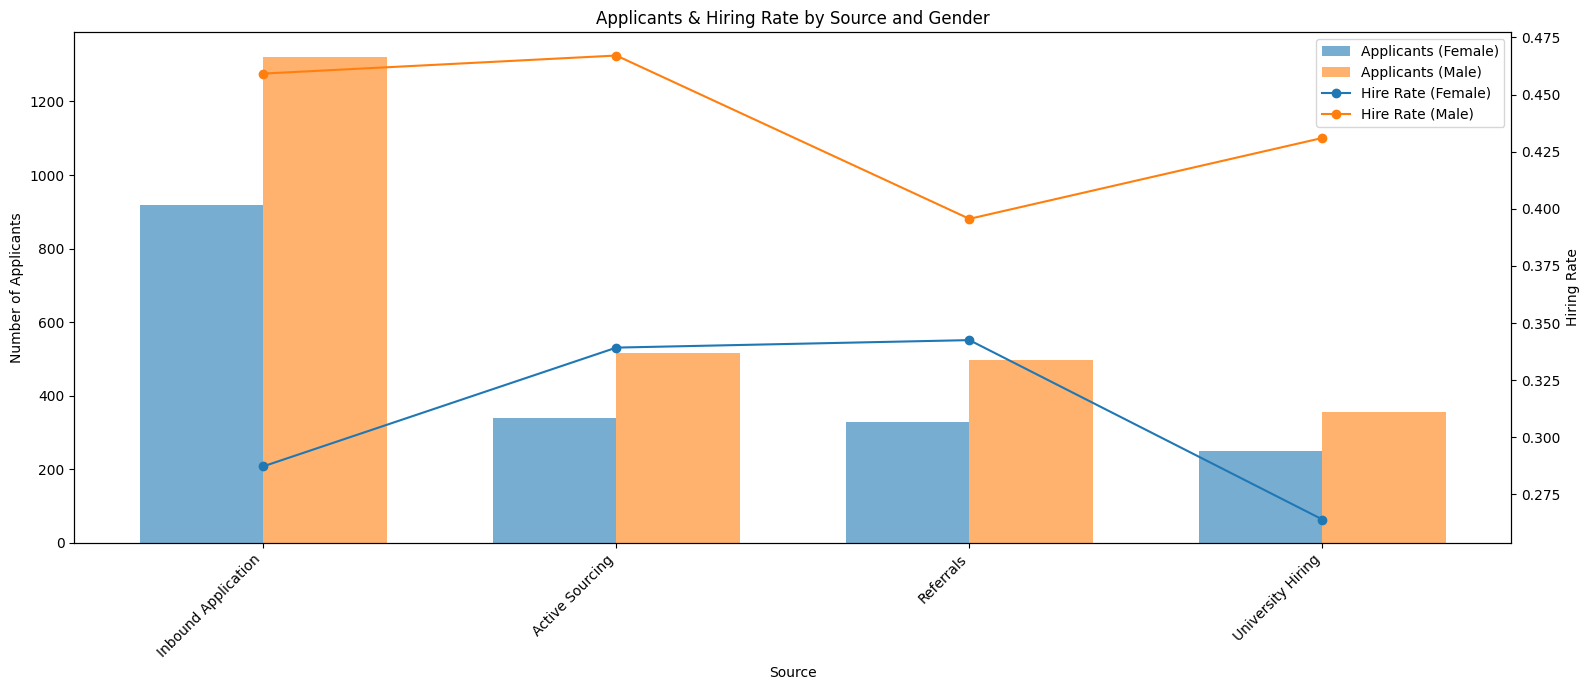

In [9]:
#Application & Hiring rate by Gender & Source

df_source = df_clean.copy()

# Aggregate by Source & Gender
source_stats = (
    df_source.assign(is_hired=(df_source["Outcome"] == "hired").astype(int))
      .groupby(["Source", "gender_norm"])
      .agg(
          applicants=("is_hired", "size"),
          hires=("is_hired", "sum")
      )
      .reset_index()
)
# Hiring rate
source_stats["hire_rate"] = source_stats["hires"] / source_stats["applicants"]

#Sort Source
source_order = (
    source_stats.groupby("Source")["applicants"]
              .sum()
              .sort_values(ascending=False)
              .index
)
source_stats["Source"] = pd.Categorical(
    source_stats["Source"],
    categories=source_order,
    ordered=True
)

#Chart
fig, ax1 = plt.subplots(figsize=(16, 7))
ax2 = ax1.twinx()
female = source_stats[source_stats["gender_norm"] == "female"].sort_values("Source")
male   = source_stats[source_stats["gender_norm"] == "male"].sort_values("Source")
x = range(len(source_order))
bar_width = 0.35
#Bars: applicants (primary axis)
ax1.bar(
    [i - bar_width/2 for i in x],
    female["applicants"],
    width=bar_width,
    alpha=0.6,
    label="Applicants (Female)"
)
ax1.bar(
    [i + bar_width/2 for i in x],
    male["applicants"],
    width=bar_width,
    alpha=0.6,
    label="Applicants (Male)"
)
ax1.set_xlabel("Source")
ax1.set_ylabel("Number of Applicants")
ax1.set_xticks(x)
ax1.set_xticklabels(source_order, rotation=45, ha="right")
# Lines: hire rate (secondary axis)
ax2.plot(
    x,
    female["hire_rate"],
    marker="o",
    label="Hire Rate (Female)"
)
ax2.plot(
    x,
    male["hire_rate"],
    marker="o",
    label="Hire Rate (Male)"
)
ax2.set_ylabel("Hiring Rate")
# Title & legend
ax1.set_title("Applicants & Hiring Rate by Source and Gender")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper right")
plt.tight_layout()
plt.show()


# Two-proportion Z-test
- Null Hypothesis:	Gender does not affect Hiring rate (Ho: p1 = p2)
- Alternative Hypothesis:	Gender does affect Hiring rate (Ha: p1 ≠ p2)
- Confidence level	95%

In [10]:
# Hired rate by Gender
summary = (
    df_clean.assign(is_hired=(df_clean["Outcome"] == "hired").astype(int))
      .groupby("gender_norm")
      .agg(hired=("is_hired","sum"), total=("is_hired","size"))
)

summary["hire_rate"] = summary["hired"] / summary["total"]
display(summary)


,hired,total,hire_rate
gender_norm,,,
female,557,1835,0.303542
male,1198,2691,0.445188


In [11]:
# Z-test inputs

x_male = int(summary.loc["male", "hired"])
n_male = int(summary.loc["male", "total"])

x_fem  = int(summary.loc["female", "hired"])
n_fem  = int(summary.loc["female", "total"])

print("Male   hired/total:", x_male, "/", n_male, "rate =", x_male/n_male)
print("Female hired/total:", x_fem,  "/", n_fem,  "rate =", x_fem/n_fem)


Male   hired/total: 1198 / 2691 rate = 0.4451876625789669
Female hired/total: 557 / 1835 rate = 0.30354223433242505


## Z-test results
- p-value ≈ 0 < α	= 0.05: Reject Ho (There exist a statistically significant difference in Hiring rates between male and female candidates)
- At this stage, the test detects a difference, but it does not explain what causes that difference.
- Further analysis is required to distinguish between compositional (Department, Gender, Source, Time mix) effects and Gender bias



In [14]:
# Z-test results

count = np.array([x_male, x_fem])
nobs  = np.array([n_male, n_fem])

z_stat, p_value = proportions_ztest(count, nobs, alternative="two-sided")

print("z statistic:", z_stat)
print("p-value (two-sided):", p_value)


z statistic: 9.602358065159185
p-value (two-sided): 7.813600388994533e-22


## Confidence Interval CI
- The difference in Hiring rates lies between 11.3 and 17.0 percentage points in favor of male candidates

In [13]:
# Confidence Interval CI

from math import sqrt
p_male = x_male / n_male
p_fem  = x_fem  / n_fem
se_unpooled = sqrt(p_male*(1-p_male)/n_male + p_fem*(1-p_fem)/n_fem)
ci_low  = (p_male - p_fem) - 1.96*se_unpooled
ci_high = (p_male - p_fem) + 1.96*se_unpooled

print("95% CI for (Male - Female) hire rate difference:")
print("[", ci_low, ",", ci_high, "]")


95% CI for (Male - Female) hire rate difference:
[ 0.1134464473283682 , 0.16984440916471552 ]


# Multivariate Logistic Regression model
- Pr(Hired) = f(Gender,Department,Source,Interview Month)
- Holding Department, Source, and Timing constant, does gender independently affect the probability of being hired?



In [ ]:
# Binary Outcome: 1 = hired, 0 = archived
df_clean["binary_outcome"] = np.where(df_clean["Outcome"] == "hired", 1, 0)
display(df_clean["binary_outcome"].value_counts())


,count
binary_outcome,
0,2772
1,1756


In [ ]:
# Time control variable MM-YYYY
df_clean["interview_date"] = pd.to_datetime(df_clean["interview_date"])
df_clean["interview_month"] = df_clean["interview_date"].dt.to_period("M").astype(str)
display(df_clean["interview_month"].value_counts().head())


,count
interview_month,
2023-09,438
2023-03,433
2023-10,424
2023-11,423
2023-07,422


In [ ]:
# Fit the Multivariate logistic regression: Binary Outcome ~ gender + department + source + time

logistic_regression = "binary_outcome ~ C(gender_norm) + C(Department) + C(Source) + C(interview_month)"
model = smf.logit(formula=logistic_regression, data=df_clean).fit(disp=False)
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:         binary_outcome   No. Observations:                 4528
Model:                          Logit   Df Residuals:                     4505
Method:                           MLE   Df Model:                           22
Date:                Tue, 13 Jan 2026   Pseudo R-squ.:                  0.1477
Time:                        06:34:19   Log-Likelihood:                -2576.9
converged:                      False   LL-Null:                       -3023.6
Covariance Type:            nonrobust   LLR p-value:                8.813e-175
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.7183      0.259      6.636      0.000       1.211       2.226
C(gender_norm)[T.male]              -0.1006      0.081     -1.240

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Interpetation of Odds Ratios & Confidence Interval
- Gender: It is not a statistically significant predictor of Hiring once other Variables are controlled
  - Compare to Female, Male has 10% lower Hiring odds (OR=0.90), but it is not statistically signifficant (p-value: 0.215 > α: 0.05)
- Department: It is the main contributor for Hiring outcomes
  - People, Marketing, Support & Sales are the Departments with high number of Female applicants, but with very low Hiring odds (OR = 3.5%, 17.5%, 27.3%, 28.1% respectively) when compared to Engineering
  - Engineering & Product Departments are dominated by Male applications, and are the ones with the outstanding Hiring odds (OR = 92%, 100% rspectively)
  - Gender bias detected in the Two-proportion Z-test arise primarily because Genders apply to Departments with very different Hiring odds, not because of Gender-based decision differences
- Source: Its effect on Hiring is modest compared to Department
  - The effect of the different Source types is not signifficant (all p-values > α: 0.05)
  - It does not introduce Gender disadvantage once Department and Time are controlled
- Time: Hiring probability varies meaningfully over time
  - Monthly odd rations range from 33% to 55% and are statistically signifficant
  - This effect could be related to other varibles like seasonality, or hiring cycles not considered in this study

In [ ]:
# Odds Ratios & Confidence Interval
params = model.params
conf = model.conf_int()
conf.columns = ["2.5%", "97.5%"]

or_table = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_2.5%": np.exp(conf["2.5%"]),
    "OR_97.5%": np.exp(conf["97.5%"]),
    "p_value": model.pvalues
}).sort_values("p_value")

display(or_table)
or_table.to_csv("or_table.csv")

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,coef,OR,OR_2.5%,OR_97.5%,p_value
C(Department)[T.People],-3.343179,3.532449e-02,0.025268,0.049382,3.485295e-85
C(Department)[T.Marketing],-1.742756,1.750373e-01,0.136530,0.224405,5.228471e-43
C(Department)[T.Support],-1.299925,2.725523e-01,0.221231,0.335779,2.663381e-34
C(Department)[T.Sales],-1.271179,2.805006e-01,0.227357,0.346066,1.883970e-32
Intercept,1.718326,5.575187e+00,3.356250,9.261142,3.219803e-11
C(interview_month)[T.2023-03],-1.095852,3.342548e-01,0.202762,0.551022,1.733045e-05
C(interview_month)[T.2023-02],-1.095036,3.345276e-01,0.200974,0.556831,2.530386e-05
C(interview_month)[T.2023-07],-1.042938,3.524177e-01,0.213768,0.580996,4.335393e-05
C(interview_month)[T.2023-12],-1.013017,3.631216e-01,0.216635,0.608661,1.210801e-04
C(interview_month)[T.2023-08],-0.986610,3.728386e-01,0.225328,0.616917,1.230986e-04


# Final conclusion:
- On a first glance, the univariate analysis shows that Hiring rates differ substantially by Gender
- But after adjusting for Department, Source, and Time, the multivariate analysis proves that Gender is not a statistically significant predictor of Hiring outcomes. Differences in hiring rates are driven primarily by Department selectivity and Timing, rather than Gender bias in the hiring process